In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from scipy import interp
from sklearn.metrics import roc_curve, auc


# EDA

Do we have any null values? <br>
How many rows and columns do we have? <br>
What is the target variable? <br>
By filtering on the target variable, how many policies do we have and how many non-policies do we have?<br>
Is our data unbalanced on the target variable?<br>


In [20]:
df_main = pd.read_csv("caravan-insurance-challenge.csv")

In [21]:
df_main.isnull().values.any()

False

There is no Null value in the dataset

In [22]:
df_main.shape

(9822, 87)

There are 9822 rows and 87 columns

df_main.CARAVAN is the target variable

In [23]:
sum(df_main.CARAVAN), df_main.shape[0] - sum(df_main.CARAVAN)

(586, 9236)

586 policies and 9236 non policies

Not Insured:  9236
Insured:  586


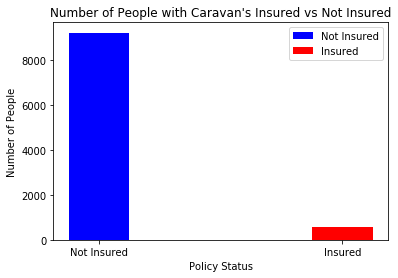

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


Not_Insured_with_caravan = sum(df_main['CARAVAN'] == 0)

Insured_with_caravan = sum(df_main['CARAVAN'] == 1)

plt.bar('Not Insured', Not_Insured_with_caravan, color = 'b', width = 0.25, label='Not Insured')
plt.bar('Insured', Insured_with_caravan, color = 'r', width = 0.25, label='Insured')

#X = np.arange(1)
print("Not Insured: ",Not_Insured_with_caravan)
print("Insured: ", Insured_with_caravan)

plt.title("Number of People with Caravan's Insured vs Not Insured")
plt.xlabel("Policy Status")
plt.ylabel("Number of People")
plt.legend(loc='upper right')



## Example of Resampling (Oversampling)
<br>
Now let’s resample our dataset by “oversampling” on the insured.  What did this do to our data set?


Not Insured:  9236
Insured:  9236


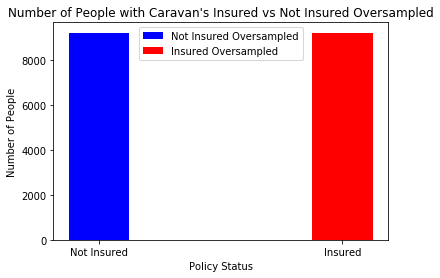

In [8]:
from sklearn.utils import resample

not_insured= df_main[df_main['CARAVAN'] == 0]
insured = df_main[df_main['CARAVAN'] == 1]


insurance_upsampled = resample(insured,
                          replace=True, # sample with replacement
                          n_samples=len(not_insured), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_insured, insurance_upsampled])

upsampled_not_insured = sum(upsampled['CARAVAN'] == 0)
upsampled_insured = sum(upsampled['CARAVAN'] == 1)

plt.bar('Not Insured', upsampled_not_insured, color = 'b', width = 0.25, label='Not Insured Oversampled')
plt.bar('Insured', upsampled_insured, color = 'r', width = 0.25, label='Insured Oversampled')
plt.title("Number of People with Caravan's Insured vs Not Insured Oversampled")

plt.xlabel("Policy Status")
plt.ylabel("Number of People")
plt.legend(loc='upper center')

#X = np.arange(1)
print("Not Insured: ",upsampled_not_insured)
print("Insured: ", upsampled_insured)


## Train and Test
<br>Split the data into training and test sets (hint: there is a variable in the data set that already done this for <br>you) and call them df_train and df_test
<br>Create an a dataset that includes all the independent variables (hint: use iloc to skip the first and last <br>column) and call them df_train_x, df_test_x
<br>Create 2 dataframes that ONLY includes the target variable df_train_y and df_test_y<br>
 



In [54]:
df_train = df_main[df_main["ORIGIN"] == "train"]
df_test = df_main[df_main["ORIGIN"] == "test"]

In [55]:
df_train_x = df_train.iloc[:, 1:-1]
df_test_x = df_test.iloc[:, 1:-1]

In [56]:
df_train_y = df_train["CARAVAN"]
df_test_y = df_test["CARAVAN"]

In [62]:
sum(df_train_y), len(df_train_y)- sum(df_train_y)

(348, 5474)

## Dealing with Unbalanced Data
<br>
Since we have unbalanced data, let’s rebalance the target for better classification results

In [64]:
# Random Undersampling
rus = RandomUnderSampler(random_state=77)
rus_x_train, rus_y_train = rus.fit_resample(df_train_x, df_train_y)

# Random Oversampling
#ENTER YOUR OWN CODE
ros = RandomOverSampler(random_state=77)
ros_x_train, ros_y_train = ros.fit_resample(df_train_x, df_train_y)

# SMOTE
#ENTER YOUR OWN CODE
sm = SMOTE(random_state=77)
sm_x_train, sm_y_train = sm.fit_resample(df_train_x, df_train_y)


#put all the different datasets into a single list so we can iterate over it.
train_sample_labels = ["Unbalanced", "Undersample", "Oversample", "SMOTE"]
train_samples = [(df_train_x, df_train_y), (rus_x_train, rus_y_train), (ros_x_train, ros_y_train), (sm_x_train, sm_y_train)]


# Classification Modeling and Conclusions<br>
Can you predict who would be interested in buying a caravan insurance policy by building multiple models and comparing the AUC? (Area Under the Curve)


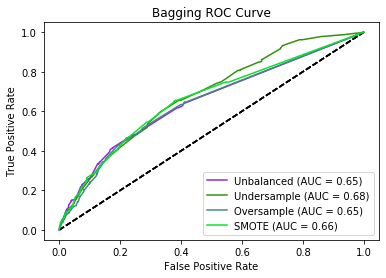

In [65]:
ensemble = []

i = 0
for sample in train_samples:
    bag = BaggingClassifier(None, 20, random_state = 1)
    bag.fit(sample[0],sample[1])
    y_pred_prob = bag.predict_proba(df_test_x)[:,1]
    fpr, tpr, thresholds = roc_curve(df_test_y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ensemble.append((roc_auc, "Bagging", train_sample_labels[i]))
    label='%s (AUC = %0.2f)' % (train_sample_labels[i], roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label, color=np.random.rand(3))
    i += 1
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging ROC Curve')
plt.legend(loc="lower right")
plt.show()


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


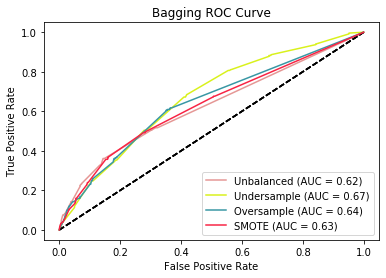

In [69]:
ensemble = []

i = 0
for sample in train_samples:
    bag = RandomForestClassifier(random_state=1)
    bag.fit(sample[0],sample[1])
    y_pred_prob = bag.predict_proba(df_test_x)[:,1]
    fpr, tpr, thresholds = roc_curve(df_test_y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ensemble.append((roc_auc, "Bagging", train_sample_labels[i]))
    label='%s (AUC = %0.2f)' % (train_sample_labels[i], roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label, color=np.random.rand(3))
    i += 1
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging ROC Curve')
plt.legend(loc="lower right")
plt.show()


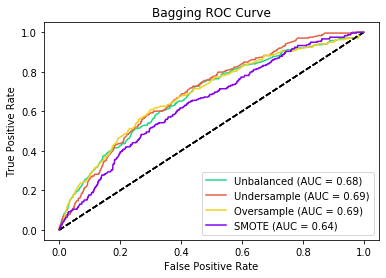

In [67]:
AdaBoostClassifier
ensemble = []

i = 0
for sample in train_samples:
    bag = AdaBoostClassifier(None, 20, random_state = 1)
    bag.fit(sample[0],sample[1])
    y_pred_prob = bag.predict_proba(df_test_x)[:,1]
    fpr, tpr, thresholds = roc_curve(df_test_y, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    ensemble.append((roc_auc, "Bagging", train_sample_labels[i]))
    label='%s (AUC = %0.2f)' % (train_sample_labels[i], roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label=label, color=np.random.rand(3))
    i += 1
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Bagging ROC Curve')
plt.legend(loc="lower right")
plt.show()